<a href="https://colab.research.google.com/github/caioitalo/soulcode/blob/main/Projeto_Aquecimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXTRAÇÃO DOS DADOS


## Importação das bibliotecas e do conector do mongo

In [1]:
import pandas as pd
import numpy as np
import pymongo
from pymongo import MongoClient

In [2]:

uri = "mongodb+srv://caio-soulcode.o09ab0z.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri,
                     tls=True,
                     tlsCertificateKeyFile='/content/X509-cert-1702224064282282452.pem')

db = client['proj_aquec']
colecao1 = db['202201_orig']
colecao2 = db['202204_orig']
colecao3 = db['202210_orig']
doc_count = colecao1.count_documents({})
print(doc_count)


152140


In [ ]:
df1orig = pd.read_csv('/content/D.SDA.PDA.005.CAT.202201orig.csv',sep=';',encoding='ISO-8859-1')
df2orig = pd.read_csv('/content/D.SDA.PDA.005.CAT.202204orig.csv',sep=';',encoding='ISO-8859-1')
df3orig = pd.read_csv('/content/D.SDA.PDA.005.CAT.202210orig.csv',sep=';',encoding='ISO-8859-1')

## Carregamento dos arquivos iniciais para o MongoDB

In [ ]:
df1orig_dict = df1orig.to_dict('records')
df2orig_dict = df2orig.to_dict('records')
df3orig_dict = df3orig.to_dict('records')


In [ ]:
df2orig.dtypes

In [ ]:
# Houve um erro no momento de inserir os dados no mongoDB, foi checada cada coluna de cada DF para achar alguma inconsistência impeditiva 
# Incons.: Indica Óbito Acidente ('{ñ') - a falta do fechamento das chaves pode estar gerando problema na geração dos documentos no mongoDB
# Origem de Cadastramento CAT ('{ñ class') - mesma justif.

sorted(df3orig['Data Nascimento'].unique())

In [ ]:
# foi dado um replace em todos os dfs com tais inconsistências
df1orig.replace(['{','}'],'', regex=True, inplace=True)
df2orig.replace(['{','}'],'', regex=True, inplace=True)
df3orig.replace(['{','}'],'', regex=True, inplace=True)

In [ ]:
# Carregamento para o MongoDB para ser posto em disponibilidade
colecao1.insert_many(df1orig_dict)
colecao2.insert_many(df2orig_dict)
colecao3.insert_many(df3orig_dict)

#colecao2.count_documents({})

## Carregamento dos arquivos iniciais para o Cloud Storage

In [3]:
#importação das bibliotecas da cloud storage
!pip install gcsfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Realizando a configuração da conta utilizando a chave json
from google.cloud import storage
import os

serviceAccount = '/content/sc-bc26-ed7-adb0dc2607d9.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount


In [5]:
# Acessando o bucket, e inserindo os arquivos
cliente = storage.Client()
bucket = cliente.get_bucket('datalake-soulcode-ed7')

In [ ]:
blob = bucket.blob('proj_aquec/D.SDA.PDA.005.CAT.202201orig.csv')
blob.upload_from_filename('/content/D.SDA.PDA.005.CAT.202201orig.csv')

In [ ]:
blob = bucket.blob('proj_aquec/D.SDA.PDA.005.CAT.202204orig.csv')
blob.upload_from_filename('/content/D.SDA.PDA.005.CAT.202204orig.csv')

In [ ]:
blob = bucket.blob('proj_aquec/D.SDA.PDA.005.CAT.202210orig.csv')
blob.upload_from_filename('/content/D.SDA.PDA.005.CAT.202210orig.csv')

# CARREGAMENTO INICIAL DOS DADOS

Agora com os arquivos com disponibilidade em nuvem (GCP e MongoDB), serão carregados para transformação

In [6]:
# Carregando os DBs e os transformando em DFs do Pandas
df10 = pd.read_csv('https://storage.googleapis.com/datalake-soulcode-ed7/proj_aquec/D.SDA.PDA.005.CAT.202201orig.csv',sep=';',encoding = 'ISO-8859-1')
df20 = pd.read_csv('https://storage.googleapis.com/datalake-soulcode-ed7/proj_aquec/D.SDA.PDA.005.CAT.202204orig.csv',sep=';',encoding = 'ISO-8859-1')
df30 = pd.read_csv('https://storage.googleapis.com/datalake-soulcode-ed7/proj_aquec/D.SDA.PDA.005.CAT.202210orig.csv',sep=';',encoding = 'ISO-8859-1')

In [7]:
# unindo os três datasets, usando o concat pois têm o mesmo número de colunas e o que muda são as datas. Não há uma coluna como ID para dar merge.
df = pd.concat([df10,df20,df30])

In [8]:
# gerando um backup
dfback = df.copy()

# TRANFORMAÇÃO - PANDAS

## Transformações


In [ ]:
df.head(4)

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,...,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
0,{ñ class},2022/01,515105-Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,Empregador,Pa,Empregado,Não,...,Feminino,Doença,Maranhão,São Paulo,2022/01,0000/00,20/01/2022,02/08/1970,01/03/2022,57.571.275.002.570
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,...,Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,...,Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
3,"Aprision. Em, Sobre ou Entre Dois ou Mai",2022/02,514205-Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,Empregador,Pa,Empregado,Não,...,Masculino,Típico,{ñ class},Goiás,2022/02,0000/00,24/02/2022,19/09/1986,01/03/2022,00.000.000.000.000


In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
df.shape

(257401, 24)

In [ ]:
# Checando valores vazios
df.isna().sum()

Agente  Causador  Acidente     0
Data Acidente                  0
CBO                            0
CID-10                         0
CNAE2.0 Empregador             0
CNAE2.0 Empregador.1           0
Emitente CAT                   0
Espécie do benefício           0
Filiação Segurado              0
Indica Óbito Acidente          0
Munic Empr                     0
Natureza da Lesão              0
Origem de Cadastramento CAT    0
Parte Corpo Atingida           0
Sexo                           0
Tipo do Acidente               0
UF  Munic.  Acidente           0
UF Munic. Empregador           0
Data Acidente.1                0
Data Despacho Benefício        0
Data Acidente.2                0
Data Nascimento                0
Data Emissão CAT               0
CNPJ/CEI Empregador            0
dtype: int64

In [ ]:
# Checando se há linhas duplicadas
df[df.duplicated(keep=False)]

,Agente Causador Acidente,Data Acidente,CBO,CID-10,CNAE2.0 Empregador,CNAE2.0 Empregador.1,Emitente CAT,Espécie do benefício,Filiação Segurado,Indica Óbito Acidente,...,Sexo,Tipo do Acidente,UF Munic. Acidente,UF Munic. Empregador,Data Acidente.1,Data Despacho Benefício,Data Acidente.2,Data Nascimento,Data Emissão CAT,CNPJ/CEI Empregador
1,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,...,Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
2,"Motocicleta, Motoneta",2022/02,519110-Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,Segurado/Dependente,Pa,Empregado,Não,...,Masculino,Trajeto,Maranhão,São Paulo,2022/02,0000/00,25/02/2022,16/12/1990,01/03/2022,19.578.086.000.162
212,"Motocicleta, Motoneta",2022/02,521125-Repositor de Mercadorias,L08.8 Outr Infecc Local Espec Pele Tec Subcut,4744,"Comercio Varejista de Ferragens, Madeira e Ma",Empregador,Pa,Empregado,Não,...,Masculino,Trajeto,Pará,Pernambuco,2022/02,0000/00,20/02/2022,17/07/2002,01/03/2022,00.000.000.000.000
265,"Motocicleta, Motoneta",2022/02,521125-Repositor de Mercadorias,S90.7 Traum Superf Mult do Tornozelo e do Pe,4744,"Comercio Varejista de Ferragens, Madeira e Ma",Empregador,Pa,Empregado,Não,...,Masculino,Trajeto,Pará,Pernambuco,2022/02,0000/00,13/02/2022,15/12/1994,01/03/2022,00.000.000.000.000
274,"Motocicleta, Motoneta",2022/02,521125-Repositor de Mercadorias,S90.7 Traum Superf Mult do Tornozelo e do Pe,4744,"Comercio Varejista de Ferragens, Madeira e Ma",Empregador,Pa,Empregado,Não,...,Masculino,Trajeto,Pará,Pernambuco,2022/02,0000/00,13/02/2022,15/12/1994,01/03/2022,00.000.000.000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4842,"Aprision. Em, Sobre ou Entre Objeto Para",2022/10,"784105-Embalador, a Mão",S62.6 Frat de Outr Dedos,2222,Fabricacao de Embalagens de Material Plastico,Empregador,Pa,Empregado,Não,...,Masculino,Típico,Maranhão,São Paulo,2022/10,0000/00,13/10/2022,16/05/1966,14/10/2022,00.000.000.000.000
8104,Impacto Sofrido por Pes. de Objeto Que Cai,2022/09,715210-Pedreiro,S62.2 Frat do Primeiro Metacarpiano,4330,Obras de Acabamento,Empregador,Pa,Empregado,Não,...,Masculino,Típico,Roraima,Paraná,2022/09,0000/00,14/09/2022,30/07/1981,21/10/2022,00.000.000.000.000
8118,Impacto Sofrido por Pes. de Objeto Que Cai,2022/09,715210-Pedreiro,S62.2 Frat do Primeiro Metacarpiano,4330,Obras de Acabamento,Empregador,Pa,Empregado,Não,...,Masculino,Típico,Roraima,Paraná,2022/09,0000/00,14/09/2022,30/07/1981,21/10/2022,00.000.000.000.000
13391,Reacao do Corpo a Movimento Voluntario,2022/10,414110-Armazenista,S93.4 Entorse e Distensao do Tornozelo,4622,Comercio Atacadista de Soja,Empregador,Pa,Empregado,Não,...,Masculino,Típico,{ñ class},Rio Grande do Sul,2022/10,0000/00,03/10/2022,29/09/1996,05/10/2022,00.000.000.000.000


In [ ]:
df = df.drop_duplicates()

In [9]:
# Comparando as duas colunas da tabela
df['Data Acidente.1'].equals(df['Data Acidente'])

True

In [10]:
# dropando uma das colunas iguais
# dropando Origem do cadastramento, pois só exibe um valor, sendo irrelevante para as análises.
df.drop('Data Acidente',axis=1,inplace=True)
df.drop('Origem de Cadastramento CAT',axis=1,inplace=True)

In [11]:
# Renomeando as colunas para deixá-las mais fáceis
df.rename(columns={'Agente  Causador  Acidente':'ag_causador', 'CID-10':'cid10','CNAE2.0 Empregador':'cod_cnae',
                   'CNAE2.0 Empregador.1':'desc_cnae','Emitente CAT':'emitente_cat','Espécie do benefício':'tipo_beneficio',
                   'Filiação Segurado':'filiacao_seg','Indica Óbito Acidente':'obito','Munic Empr':'munic_empregador',
                   'Natureza da Lesão':'nat_lesao','Parte Corpo Atingida':'local_da_lesao','Tipo do Acidente':'tipo_acid',
                   'UF  Munic.  Acidente':'uf_acid','UF Munic. Empregador':'uf_empregador','Data Acidente.1':'dt_acid',
                    'Data Despacho Benefício':'dt_desp_ben', 'Data Acidente.2':'data','Data Nascimento':'dt_nasc','Data Emissão CAT':'dt_emissao_cat',
                   'CNPJ/CEI Empregador':'cnpj_cei'},inplace=True)

In [ ]:
df.dtypes

ag_causador         object
cbo                 object
cid10               object
cod_cnae             int64
desc_cnae           object
emitente_cat        object
tipo_beneficio      object
filiacao_seg        object
obito               object
munic_empregador    object
nat_lesao           object
local_da_lesao      object
sexo                object
tipo_acid           object
uf_acid             object
uf_empregador       object
dt_acid             object
dt_desp_ben         object
data                object
dt_nasc             object
dt_emissao_cat      object
cnpj_cei            object
dtype: object

In [12]:
#criando uma lista para armazenar os IDs e após isso inserando na tabela
id = []
for i in range(len(df)):
  id.append(str(i))
  
df.insert(0,'id',id)

In [ ]:
# usando unique novamente para checar inconsistências de cada coluna
# Inconsistências: valores com muitos espaços - ok, {ñ class} - ok ,{ñ - ok
# tipo_beneficio: 'Pa' é uma inconsistência?
# separar as colunas para ver melhor: cbo, cid10, munic_empregador
# sexo: 'Não Informado' -ok, 'Indeterminado' é inconsistência?
# tipo_acid: 'Ignorado' - ok
# uf_acid: 'Zerado' - ok
# dt_nasc, dt_desp_ben, dt_emissao_cat: 00/00/0000 - ok
# olhar o cnpj_cei: 00.000.000.000.000 - ok

sorted(df['dt_nasc'].unique(),reverse=True)

In [13]:
# Usando python para percorrer as colunas e retirar o excesso de espaços. foi necessário transformar cod_cnae em string para utilizar esse método.
df['cod_cnae'] = df['cod_cnae'].astype(str)
for coluna in df:
  df[coluna] = df[coluna].str.strip()


In [14]:
# Trocando os valores inconsistentes. 
# Trocando os valores por NI, para manter um padrão de dados que não foram informados/ignorados/inconsistentes.
# Data foi passado para NaN pois o structype do spark não aceitaria String na coluna
df.replace('{ñ class}','NI',inplace=True)
df.replace('{ñ', 'NI',inplace=True)
df.replace('Zerado', 'NI',inplace=True)
df.replace('Ignorado', 'NI',inplace=True)
df.replace('00.000.000.000.000', 'NI',inplace=True)
df.replace('0000/00', 'NI',inplace=True)
df.replace('00/00/0000', np.nan,inplace=True)
df['Sexo'].replace('Não Informado','NI',inplace=True)


In [15]:
# tratamos o 00/00/0000 como NaN para ser possível transformá-lo em data a fim de ser possível colocá-lo em Struct Type em Pyspark.
df['data'] = pd.to_datetime(df['data'],dayfirst=True)
df['dt_nasc'] = pd.to_datetime(df['dt_nasc'],dayfirst=True)
df['dt_emissao_cat'] = pd.to_datetime(df['dt_emissao_cat'],dayfirst=True)


## Plotagem de Gráficos


In [ ]:
#importando a biblioteca 
import matplotlib

In [ ]:
df.dtypes

ag_causador         object
cbo                 object
cid10               object
cod_cnae            object
desc_cnae           object
emitente_cat        object
tipo_beneficio      object
filiacao_seg        object
obito               object
munic_empregador    object
nat_lesao           object
local_da_lesao      object
sexo                object
tipo_acid           object
uf_acid             object
uf_empregador       object
dt_acid             object
dt_desp_ben         object
data                object
dt_nasc             object
dt_emissao_cat      object
cnpj_cei            object
dtype: object

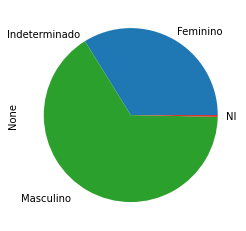

In [ ]:
# Plotagem de CAT/sexo. Pode-se notar uma prepoderância do sexo masculino em acidentes de trabalho
df.groupby('Sexo').size().plot.pie()

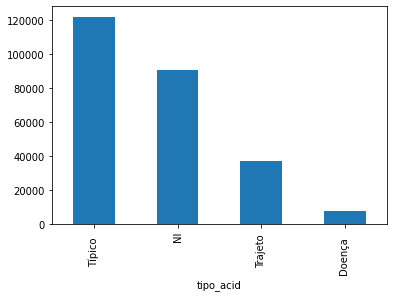

In [ ]:
# O acidente típico é aquele mais corriqueiro. Ex.: quando um marceneiro serra o próprio dedo, gerando uma incapacidade.
# Nota-se uma grande quantidade de NI nos dados colocados.
df.groupby('tipo_acid',).size().sort_values(ascending=False).plot.bar()

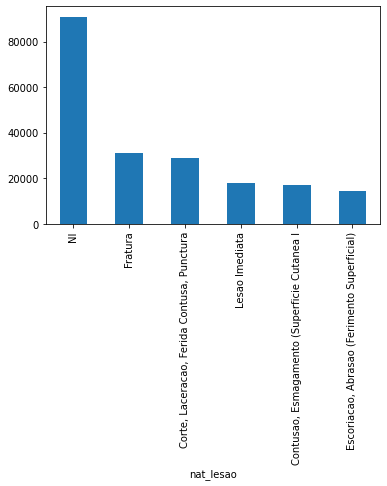

In [ ]:
# 6 maiores casos de natureza de lesão na BD
df.groupby('nat_lesao').size().sort_values(ascending=False).head(6).plot.bar()

# TRANFORMAÇÃO - PYSPARK

## Transformações

In [16]:
# Instalando e importando as bibliotecas pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 199 kB 69.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=f4dd54496f3fc22179309176a3ec3266161934a27b309465da534a66b34abb98
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [17]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import * 

In [18]:
# Construindo e carregando a Spark Session
spark = (SparkSession.builder
         .master('local')
         .appName('proj_aquec')
         .config('spark.ui.port','4050')
         .getOrCreate()

)

In [19]:
# Construindo o struct types do DF-spark
esquema = (
    StructType([
        StructField('id', StringType()),
        StructField('ag_causador', StringType()),
        StructField('CBO', StringType()),
        StructField('cid10', StringType()),
        StructField('cod_cnae', StringType()),
        StructField('desc_cnae', StringType()),
        StructField('emitente_cat', StringType()),
        StructField('tipo_beneficio', StringType()),
        StructField('filiacao_seg', StringType()),
        StructField('obito', StringType()),
        StructField('munic_empregador', StringType()),
        StructField('nat_lesao', StringType()),
        StructField('local_da_lesao', StringType()),
        StructField('Sexo', StringType()),
        StructField('tipo_acid', StringType()),
        StructField('uf_acid', StringType()),
        StructField('uf_empregador', StringType()),
        StructField('dt_acid', StringType()),   
        StructField('dt_desp_ben', StringType()),
        StructField('data', DateType()),     
        StructField('dt_nasc', DateType()),
        StructField('dt_emissao_cat', DateType()),
        StructField('cnpj_cei', StringType())
    ])
)

In [20]:
# Criando um Dataframe em Spark
dfsp = spark.createDataFrame(df,schema=esquema)

In [21]:
dfspbackup = dfsp

In [ ]:
dfsp = dfspbackup

In [ ]:
dfsp.show(4)

+---+--------------------+--------------------+--------------------+--------+--------------------+-------------------+--------------+------------+-----+--------------------+--------------------+--------------------+---------+---------+--------+-------------+-------+-----------+----------+----------+--------------+------------------+
| id|         ag_causador|                 CBO|               cid10|cod_cnae|           desc_cnae|       emitente_cat|tipo_beneficio|filiacao_seg|obito|    munic_empregador|           nat_lesao|      local_da_lesao|     Sexo|tipo_acid| uf_acid|uf_empregador|dt_acid|dt_desp_ben|      data|   dt_nasc|dt_emissao_cat|          cnpj_cei|
+---+--------------------+--------------------+--------------------+--------+--------------------+-------------------+--------------+------------+-----+--------------------+--------------------+--------------------+---------+---------+--------+-------------+-------+-----------+----------+----------+--------------+---------------

In [22]:
# Renomeando duas colunas com Spark
dfsp = dfsp.withColumnRenamed('CBO','cbo').withColumnRenamed('Sexo','sexo')


In [23]:
# Separação dos dados da coluna (cid10 e município do empregador) transformando em novas duas colunas de código e descrição.
# Assim, o analista conseguirá pesquisar tanto por código, como por nome.
# Com a divisão de campos, a tabela de descrição ficou sem valores, daí foi-se necessário preenchê-los com 'NI'

dfsp = (dfsp.withColumn('cod_munic_empregador',(F.split(F.col("munic_empregador"),"-")).getItem(0))
            .withColumn('munic_empregador',(F.split(F.col("munic_empregador"),"-")).getItem(1)))
dfsp = dfsp.fillna(value='NI',subset='munic_empregador')

dfsp = (dfsp.withColumn('cod_cbo',(F.split(F.col("cbo"),"-")).getItem(0))
            .withColumn('desc_cbo',(F.split(F.col("cbo"),"-")).getItem(1)))
dfsp = dfsp.fillna(value='NI',subset='desc_cbo')

In [ ]:
dfsp.show(4)

+---+--------------------+--------+--------------------+-------------------+--------------+------------+-----+--------------------+--------------------+--------------------+---------+---------+--------+-------------+-------+-----------+----------+----------+--------------+------------------+-------+--------------------+-------+--------------------+--------------+
| id|         ag_causador|cod_cnae|           desc_cnae|       emitente_cat|tipo_beneficio|filiacao_seg|obito|    munic_empregador|           nat_lesao|      local_da_lesao|     sexo|tipo_acid| uf_acid|uf_empregador|dt_acid|dt_desp_ben|      data|   dt_nasc|dt_emissao_cat|          cnpj_cei|cod_cid|            desc_cid|cod_cbo|            desc_cbo|atrso cat_dias|
+---+--------------------+--------+--------------------+-------------------+--------------+------------+-----+--------------------+--------------------+--------------------+---------+---------+--------+-------------+-------+-----------+----------+----------+----------

In [24]:
# Dessa forma, torna-se sem fundamento manter as coluna antiga com os dados unidos
dfsp = dfsp.drop('cbo')

In [25]:
# Criando uma coluna de diferença de dias entre o dia do acidente e a emissão da CAT, pois a legislação aplicável
# diz o prazo limite para emissão da CAT.
dfsp = dfsp.withColumn("atraso_cat_dias", F.datediff(F.col('dt_emissao_cat'),F.col('data')))

In [ ]:
dfsp.dtypes

In [26]:
# Reorganizando as colunas das tabelas a fim de ficar mais intuitivo
dfsp = dfsp.select('id','ag_causador','nat_lesao','local_da_lesao','cod_cbo','desc_cbo','cid10','cod_cnae','desc_cnae','cnpj_cei','emitente_cat',
                   'tipo_beneficio','filiacao_seg','obito','cod_munic_empregador','munic_empregador','uf_empregador','sexo','tipo_acid','uf_acid','dt_acid',
                   'data','dt_emissao_cat','atraso_cat_dias','dt_desp_ben','dt_nasc')

In [ ]:
dfsp.show(4,truncate=False)

+---+------------------------------------------+-------------------------------------------+------------------------------------+-------+--------------------------------------+-----------------------------------------+--------+---------------------------------------------+------------------+-------------------+--------------+------------+-----+---------------------+----------------+-------------+---------+---------+--------+-------+----------+--------------+---------------+-----------+----------+
|id |ag_causador                               |nat_lesao                                  |local_da_lesao                      |cod_cbo|desc_cbo                              |cid10                                    |cod_cnae|desc_cnae                                    |cnpj_cei          |emitente_cat       |tipo_beneficio|filiacao_seg|obito|cod_munic_empregador |munic_empregador|uf_empregador|sexo     |tipo_acid|uf_acid |dt_acid|data      |dt_emissao_cat|atraso_cat_dias|dt_desp_ben|dt_nasc 

## Window Functions

## Spark SQL

### Carregamento para o Cloud SQL (MySQL)

In [ ]:
# Instalação e importação das bibliotecas do conector MySQL-Python
!pip install mysql-connector-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.5 MB 1.2 MB/s 


In [ ]:
# Instalação e importação do conector do cloud SQL
import sys
!{sys.executable} -m pip install cloud-sql-python-connector["pymysql"] SQLAlchemy

In [ ]:
from google.cloud.sql.connector import Connector
import sqlalchemy

In [ ]:
# Definição dos parâmetros da instância, usuário, senha, e nome do DB (criado via Google Cloud)
# Criando a pool e estabelecendo a conexão com a instância SQL e o DB
INSTANCE_CONNECTION_NAME = f"sc-bc26-ed7:us-central1:aula-db"
usuario = "root"
passwd = "root"
nome_banco = "db_inss_tratado"

conector = Connector()

def con_db():
    conexao = conector.connect(INSTANCE_CONNECTION_NAME, "pymysql", user=usuario, password=passwd, db=nome_banco)
    return conexao

pool = sqlalchemy.create_engine("mysql+pymysql://",creator=con_db)

In [ ]:
# transformando o Dataframe Spark final tratado para o Pandas
dffinal = dfsp.toPandas()

In [ ]:
# Exportando o Dataframe Pandas para o Cloud SQL
dffinal.to_sql('inss_trat', con=pool, if_exists='replace')

### Insights

Realizando queries com spark SQL utilizando o comando .connect.execute() do SQLAlchemy

In [ ]:
# Segundo a legislação a CAT com óbito deve ser realizada no mesmo dia. Aqui vemos o número de casos em que a legislação foi desobedecida
pool.connect().execute('''SELECT COUNT(atraso_cat_dias) 
FROM inss_trat 
WHERE (atraso_cat_dias > 1) & (obito = "Sim") ''').fetchall()

[(430,)]

In [ ]:
# Número de casos de petição de CAT por infecção por coronavírus ainda em 2022
pool.connect().execute('''SELECT COUNT(cid10)
FROM inss_trat 
WHERE cid10 = 'B34.2 Infecc p/Coronavirus Ne'
''').fetchall()

[(2292,)]

In [ ]:
# Número de acidentes com fratura em homens
pool.connect().execute('''SELECT COUNT(nat_lesao)
FROM inss_trat 
WHERE (nat_lesao = "Fratura") & (sexo = "Masculino")
''').fetchall()

[(16175,)]

In [ ]:
# A legislação no caso de não haver óbito pede que a CAT seja feita em até 1 dia útil, a média do BD mostra um pouco longe do ideial
pool.connect().execute('''SELECT AVG(atraso_cat_dias)
FROM inss_trat 
WHERE obito = "Não"
''').fetchall()

[(9.539611501751427,)]

In [ ]:
# Média de idade (em anos) de pessoas acidentadas
pool.connect().execute('''SELECT AVG(DATEDIFF(data, dt_nasc) / 365)
FROM inss_trat ''').fetchall()

[(Decimal('37.22987315'),)]

# CARREGAMENTO FINAL

## Carregamento dos arquivos finais para o Cloud Storage

In [ ]:
# Transformação do DF spark para um arquivo csv local
dfsp.write.options(header='True', delimiter=';').csv('dataset_inss_trat.csv')

In [ ]:
# Envio do arquivo tratado para o respectivo folder no bucket
blob = bucket.blob('proj_aquec/dataset_inss_trat.csv')
blob.upload_from_filename('/content/dataset_inss_trat.csv/dataset_inss_trat.csv')

## Carregamento dos arquivos finais para o Mongo DB

In [ ]:
dffinal = dfsp.toPandas()

In [ ]:
dffinal

,id,ag_causador,nat_lesao,local_da_lesao,cod_cbo,desc_cbo,cid10,cod_cnae,desc_cnae,cnpj_cei,...,uf_empregador,sexo,tipo_acid,uf_acid,dt_acid,data,dt_emissao_cat,atraso_cat_dias,dt_desp_ben,dt_nasc
0,0,NI,Doenca Contagiosa ou Infecciosa (Tuberculos,Aparelho Respiratorio,515105,Agente Comunitário de Saúde,B34.2 Infecc p/Coronavirus Ne,8630,Atividades de Atencao Ambulatorial Executadas,57.571.275.002.570,...,São Paulo,Feminino,Doença,Maranhão,2022/01,2022-01-20,2022-03-01,40.0,NI,1970-08-02
1,1,"Motocicleta, Motoneta",Fratura,Braco (Entre O Punho a O Ombro),519110,Motociclista no Transporte de Document,S52.5 Frat da Extremidade Distal do Radio,4930,Transporte Rodoviario de Carga,19.578.086.000.162,...,São Paulo,Masculino,Trajeto,Maranhão,2022/02,2022-02-25,2022-03-01,4.0,NI,1990-12-16
2,2,"Aprision. Em, Sobre ou Entre Dois ou Mai",Luxacao,Punho,514205,Coletor Lixo,S60.0 Contusao de Dedos s/Lesao da Unha,3811,Coleta de Residuos Nao-Perigosos,NI,...,Goiás,Masculino,Típico,NI,2022/02,2022-02-24,2022-03-01,5.0,NI,1986-09-19
3,3,Impacto de Pes. Contra Objeto em Movimento,Luxacao,Perna (Entre O Tornozelo e a Pelvis),NI,NI,S90.0 Contusao do Tornozelo,4639,Comercio Atacadista de Produtos Alimenticios,NI,...,São Paulo,Masculino,Típico,Maranhão,2022/01,2022-01-28,2022-03-01,32.0,NI,1995-07-25
4,4,"Temperatura Muito Alta, Contato com Objeto Ou",Queimadura ou Escaldadura - Efeito de Tempe,Perna (Entre O Tornozelo e a Pelvis),784205,Alimentador de Linha de Prod.,T24.4 Corros Quadr Membr Inf Exc Tornoz Pe Gr,1011,"Abate de Reses, Exceto Suinos",NI,...,Bahia,Masculino,Típico,NI,2022/02,2022-02-25,2022-03-01,4.0,NI,1989-10-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156744,156744,Piso de Edificio - Superficie Utilizada Para,Lesao Imediata,Mao (Exceto Punho ou Dedos),NI,NI,S62 Frat ao Nivel do Punho e da Mao,2330,"Fabricacao de Artefatos de Concreto, Cimento,",21.161.901.000.135,...,Paraná,Masculino,Típico,Roraima,2022/09,2022-09-29,2022-10-10,11.0,2022/10,1993-09-18
156745,156745,Escada Permanente Cujos Degraus Permitem Apoi,Fratura,"Perna (Do Tornozelo, Exclusive, ao Joelho, Ex",232130,Prof. Física no Ensino Médio,S82 Frat da Perna Incl Tornozelo,8520,Ensino Medio,76.416.965.000.121,...,Paraná,Feminino,Típico,Roraima,2022/10,2022-10-06,2022-10-07,1.0,2022/11,1986-11-24
156746,156746,"Andaime, Plataforma - Edificio ou Estrutura",Fratura,"Membros Inferiores, Partes Multiplas (Qualque",517330,Vigilante,S82.7 Frat Mult da Perna,8112,Condominios Prediais,32.994.401.000.109,...,Santa Catarina,Masculino,Típico,NI,2022/09,2022-09-20,2022-10-10,20.0,2022/10,1986-03-02
156747,156747,"Martelo, Malho, Marreta- Ferramenta Manual Se",Fratura,Dedo,724315,Soldador,S62.6 Frat de Outr Dedos,7112,Servicos de Engenharia,34.197.591.000.150,...,Paraná,Masculino,Típico,Roraima,2022/10,2022-10-05,2022-10-06,1.0,2022/10,1984-04-08


In [ ]:
# Transformando os tipos de data para string, pois o mongoDB não aceita Datetype
dffinal['data'] = dffinal['data'].astype(str)
dffinal['dt_nasc'] = dffinal['dt_nasc'].astype(str)
dffinal['dt_emissao_cat'] = dffinal['dt_emissao_cat'].astype(str)

In [ ]:
db = client['proj_aquec']
colecao_final = db['inss_tratado']

In [ ]:
dffinal_dict = dffinal.to_dict('records')

In [ ]:
colecao_final.insert_many(dffinal_dict)

In [ ]:
colecao_final.count_documents({})

156749